In [15]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import galsim
import numpy as np
import anacal
import os
import matplotlib.pyplot as plt
import fitsio

Text(0, 0.5, 'PDF')

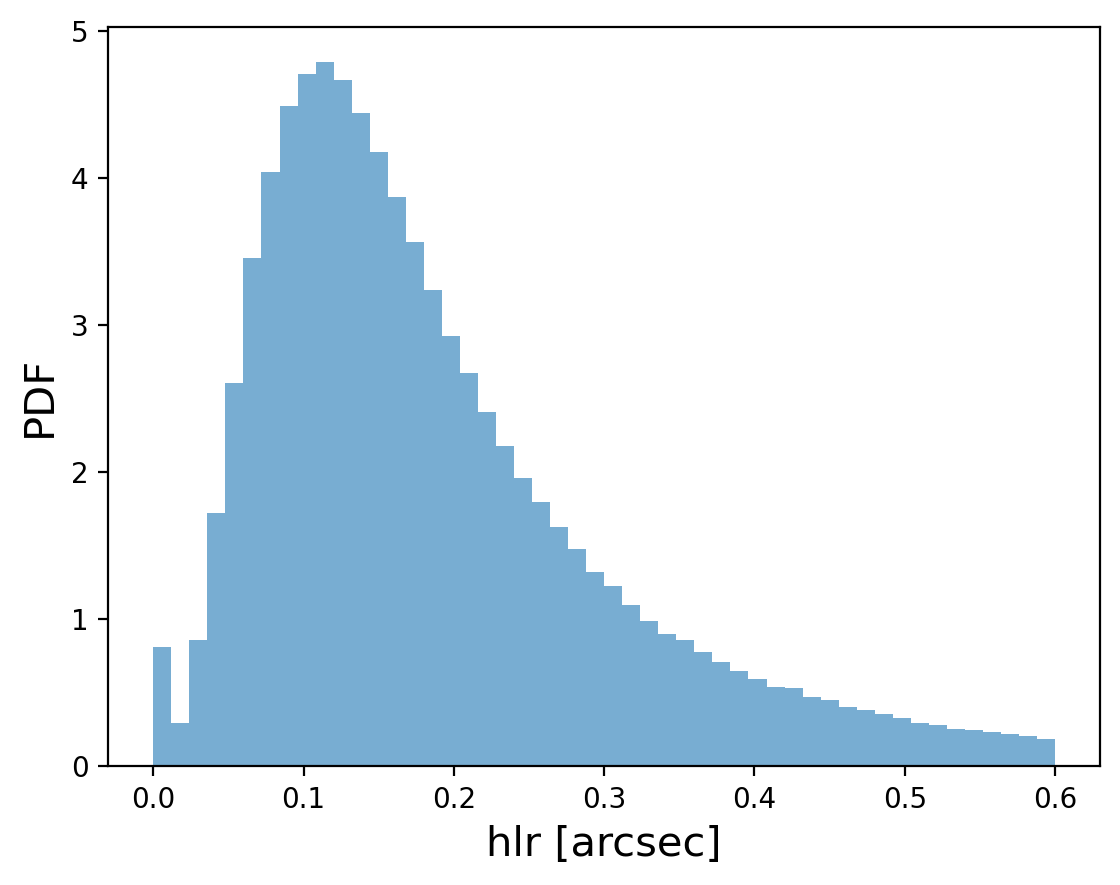

In [56]:
cat = fitsio.read(os.path.join(os.environ["CATSIM_DIR"], "OneDegSq.fits"))
hlr = np.sqrt((cat["a_d"] ** 2.0 + cat["b_d"] ** 2.0) / 2.0)
plt.hist(hlr, range=(0.0, 0.6), bins=50, density=True, alpha=0.6)
plt.xlabel("hlr [arcsec]", fontsize=15)
plt.ylabel("PDF", fontsize=15)

In [52]:
def simulate_exp_gal_stamp(
    hlr_arcsec: float,
    g1: float = 0.02,
    g2: float = 0.0,
    stamp_size: int = 64,
    pixel_scale: float = 0.2, 
    psf_beta: float = 2.0,
    psf_fwhm_arcsec: float = 0.8,
):
    # --- Profiles ---
    gal = galsim.Exponential(half_light_radius=hlr_arcsec, flux=200).shear(g1=g1, g2=g2)
    psf = galsim.Moffat(beta=psf_beta, fwhm=psf_fwhm_arcsec)

    final = galsim.Convolve([gal, psf])

    gal_img = galsim.ImageF(stamp_size, stamp_size, scale=pixel_scale)
    psf_img = galsim.ImageF(stamp_size, stamp_size, scale=pixel_scale)
    gal_img.setOrigin(0, 0)
    psf_img.setOrigin(0, 0)

    half_pixel_offset = galsim.PositionD(0.5, 0.5)

    final.drawImage(image=gal_img, method="fft", offset=half_pixel_offset)
    psf.drawImage(image=psf_img, method="fft", offset=half_pixel_offset)

    return gal_img, psf_img


def run_fpfs_and_mbias(
    gal_array: np.ndarray,
    psf_array: np.ndarray,
    pixel_scale: float,
    noise_variance: float = 0.25,
    noise_array: np.ndarray | None = None,
    g1_input: float = 0.02,
):
    npix = gal_array.shape[0]
    assert gal_array.shape == (npix, npix)
    assert psf_array.shape == (npix, npix)

    dtype = np.dtype([("y", np.int32), ("x", np.int32)])
    detection = np.empty(1, dtype=dtype)
    detection["y"] = npix // 2
    detection["x"] = npix // 2

    # FPFS config (same as your example)
    fpfs_config = anacal.fpfs.FpfsConfig(
        sigma_shapelets=0.50,
    )

    catalog = anacal.fpfs.process_image(
        fpfs_config=fpfs_config,
        mag_zero=30.0,
        gal_array=gal_array,
        psf_array=psf_array,
        pixel_scale=pixel_scale,
        noise_variance=max(noise_variance, 0.23),
        noise_array=noise_array,
        detection=detection,
    )

    e1 = catalog["fpfs_e1"]
    e1g1 = catalog["fpfs_de1_dg1"]
    mbias = np.sum(e1) / np.sum(e1g1) / g1_input - 1.0
    return mbias

def truncate_psf_to_square_keep_size(
    psf_array: np.ndarray,
    trunc_size: int,
    center_xy=(32, 32),
    renormalize: bool = True,
) -> np.ndarray:
    ny, nx = psf_array.shape
    cx, cy = center_xy
    half = trunc_size // 2

    x0, x1 = cx - half, cx + half + 1
    y0, y1 = cy - half, cy + half + 1
    out = np.zeros_like(psf_array, dtype=psf_array.dtype)
    out[y0:y1, x0:x1] = psf_array[y0:y1, x0:x1]

    if renormalize:
        s = out.sum()
        if s != 0:
            out /= s
    return out


# -------------------------
# Loop over PSF truncations
# -------------------------
noise_variance = 0.23
pixel_scale = 0.2
g1_input = 0.02

gal_img, psf_img = simulate_exp_gal_stamp(hlr_arcsec=0.05, pixel_scale=pixel_scale)
gal_array = gal_img.array
psf_array_full = psf_img.array

center_xy = (32, 32)  # your convention

trunc_sizes = list(range(25, 65, 2))

results = []
for tsize in trunc_sizes:
    psf_trunc = truncate_psf_to_square_keep_size(
        psf_array_full, trunc_size=tsize, center_xy=center_xy, renormalize=True
    )

    mbias = run_fpfs_and_mbias(
        gal_array=gal_array,         
        psf_array=psf_trunc,        
        pixel_scale=pixel_scale,
        noise_variance=noise_variance,
        noise_array=None,
        g1_input=g1_input,
    )
    results.append((tsize, mbias))

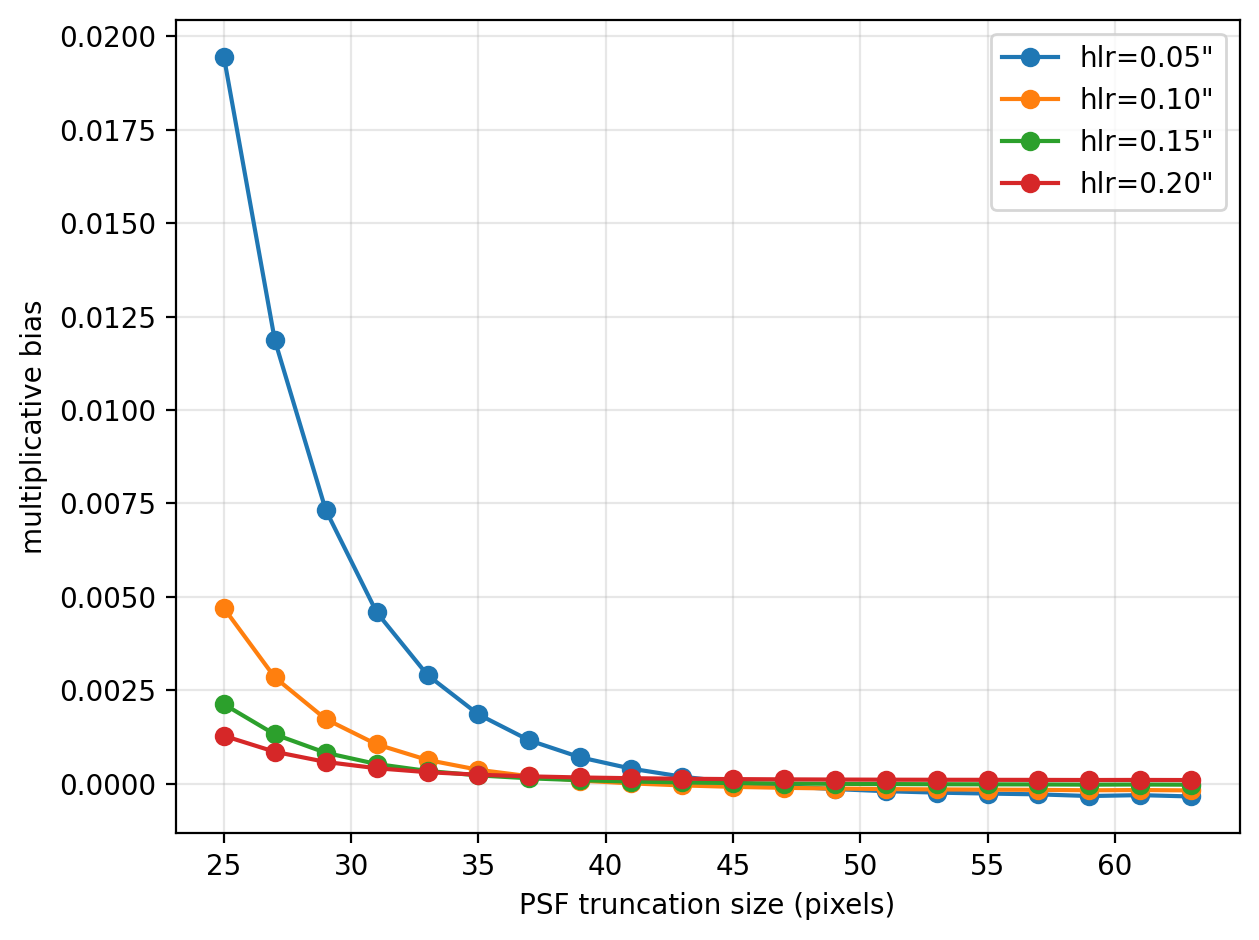

In [53]:
noise_variance = 0.23
pixel_scale = 0.2
g1_input = 0.02

center_xy = (32, 32)                 # 0-indexed center in your convention
trunc_sizes = list(range(25, 65, 2)) # 25,27,...,63
hlrs = [0.05, 0.10, 0.15, 0.20]

mbias_by_hlr = {}

for hlr in hlrs:
    gal_img, psf_img = simulate_exp_gal_stamp(hlr_arcsec=hlr, pixel_scale=pixel_scale)
    gal_array = gal_img.array
    psf_array_full = psf_img.array

    mb_list = []
    for tsize in trunc_sizes:
        psf_trunc = truncate_psf_to_square_keep_size(
            psf_array_full,
            trunc_size=tsize,
            center_xy=center_xy,
            renormalize=True,
        )

        mbias = run_fpfs_and_mbias(
            gal_array=gal_array,
            psf_array=psf_trunc,
            pixel_scale=pixel_scale,
            noise_variance=noise_variance,
            noise_array=None,
            g1_input=g1_input,
        )
        mb_list.append(mbias)

    mbias_by_hlr[hlr] = np.array(mb_list)


# ---- Plot: x = trunc stamp size, y = mbias, one curve per HLR ----
plt.figure()
for hlr in hlrs:
    plt.plot(trunc_sizes, mbias_by_hlr[hlr], marker="o", label=f"hlr={hlr:.2f}\"")

plt.xlabel("PSF truncation size (pixels)")
plt.ylabel("multiplicative bias")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
